# Analyzing a simulation

### Warm-Up exercises
- 🔎 Inspect the output of the trajectory (PDB) using a text editor
---what does the structure look like?
- 📄 Go through the documentation of MDTraj.

Once you have an MD simulation, there are a lot of paths one can take to analyze your simulation. 
In this notebook we will cover some of the major starting points to doing this

## Loading our simulation, slicing it, and saving specific structures

 To load our simulation we will use the `mdtraj` library. This library is a great tool for loading and analyzing MD simulations.
 To learn more about the library, check out the [documentation](http://mdtraj.org/).

Using `mdtraj.load` allows us to load in a single trajectory for analysis (we will cover loading multiple trajectories later).\
`mdtraj.load` autodetects the trajectory file format and loads the appropriate underlying function to load it.

Note that for `mdtraj.load` you must also specify the topology file (`.pdb` or `.gro`). This must correspond to the structure being simulated exactly (ie. matches the number of atoms)

In [2]:
# Import in our library
import mdtraj as md
# load in our trajectory
traj = md.load('output.dcd', top='first-frame.pdb')

If we just call the MDTraj `Trajectory` object, we can see some basic information about the trajectory we loaded in.\
This, in part, has us call the `topology` sub-class within `traj` to learn some of that information.

In [3]:
# print number of atoms
print("Number of atoms: %d" % traj.topology.n_atoms)
# print number of residues
print("Number of residues: %d" % traj.topology.n_residues)
# print number of frames 
print("Number of frames: %d" % traj.n_frames)

Number of atoms: 45053
Number of residues: 13949
Number of frames: 200


Fun fact, `Trajectory` objects are actually sliceable `Trajectory` objects themselves.\
This means if we want to look at any particular frame, we can simply use python array indexing to access it!\
Let's save the last frame of this trajectory (index -1). We can save any frame as a structure using the `save_pdb` function.

In [4]:
traj[-1].save_pdb('last-frame.pdb')

It's worth noting that the number of atoms and residues in our object is *so* high because our trajectory includes solvent (water + ions). 
We can use the `strip` function to remove solvent from our trajectory.

In [5]:
# remove the solvent atoms from traj
traj = traj.remove_solvent()

Now let's reprint our distances, atoms, and frames (which shouldn't change)

In [6]:
# print number of atoms
print("Number of atoms: %d" % traj.topology.n_atoms)
# print number of residues
print("Number of residues: %d" % traj.topology.n_residues)
# print number of frames 
print("Number of frames: %d" % traj.n_frames)

Number of atoms: 4044
Number of residues: 268
Number of frames: 200


The first thing we'll want to do is *image* our trajectory back into its periodic box.\
This is because we normally use periodic boundary conditions during our simulations (added during the `addSolvent` method),
which means that atoms can cross the periodic boundary and appear on the other side of the box.\
This is a problem for analysis, so we can use the `image_molecules` function to fix this.

*NOTE*: Imaging molecules and correcting for PBCs is a very case by case type of issue depending on the kind of system you're simulating.
It'll be important to verify the look of your trajectory prior 

In [7]:
# image the trajectory using MDTraj to correct for periodic boundary conditions
t2 = md.load_pdb('first-frame.pdb')
ref = t2.remove_solvent()
traj.image_molecules(anchor_molecules=ref.topology.find_molecules()[0:2], inplace=True)

<mdtraj.Trajectory with 200 frames, 4044 atoms, 268 residues, and unitcells at 0x10f1d77f0>

## Computing distances, dihedrals, and interesting features about our trajectory

There are many ways to make sense of MD trajectories that span a range of simple to complex ideas. Ultimately the workflow for making sense of trajectories has a general workflow:
1. Extract features of interest from the trajectory data
2. Analyze those features to make sense of the data (or train an ML model based on the features)
3. Visualize the results using some sort of plotting library

To start with a basic example, let's use something like end-to-end distances. The end-to-end distance may report on many things, in a protein folding trajectory a decrease in end-to-end distance may report on the degree a protein is folded or unfolded so far.\

It also offers biophysically testable predictions that we can align with experiments such as FRET (Förster resonance energy transfer) experiments.\

To measure distances, we can simply call `md.distance` and pass in the indices of the atoms we want to measure the distance between.\

In this case, we will measure the distance between the first and last atoms in the protein (the N-terminus and C-terminus).\
We can then plot the distance over time using `matplotlib` to see how the distance changes over time.

Every library for code analysis is different, but MDTraj asks us to wrap our indices in a list of lists.\
This is because we can pass in multiple pairs of atoms to measure distances between.

To take full advantage of this, let's also measure the distance from the middle of the protein to the end.

In [8]:
distances = md.compute_distances(traj, [[0, 4043], [2021, 4043]])

# Let's convert distances to a 1D numpy array
import numpy as np
distances = np.array(distances)

Now we have an array of distances that we can plot over time.

Let's plot the end-to-end distance first

Text(0.5, 0, 'Frame number')

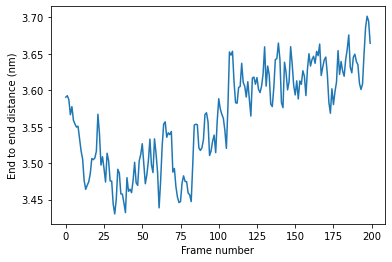

In [9]:
from matplotlib import pyplot as plt
plt.plot(traj.time, distances[:,0], '-')
plt.ylabel("End to end distance (nm)")
plt.xlabel("Frame number")

Now let's plot the middle-to-end distance!

Text(0.5, 0, 'Frame number')

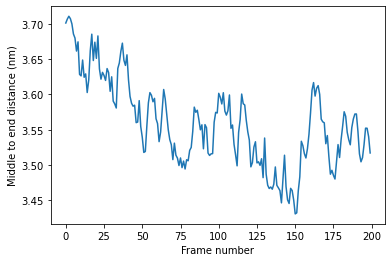

In [10]:
from matplotlib import pyplot as plt
plt.plot(traj.time, distances[:,1], '-')
plt.ylabel("Middle to end distance (nm)")
plt.xlabel("Frame number")

Looks like neither of our distances are changing very much, which is unsurprising given that this example uses just 5 frames in a trajectory, which is very little sampling.

There are other interesting features we can extract to make sense of our system, another one is the Radius of gyration (Rg).\
You can read more about Rg at [Wikipedia](https://en.wikipedia.org/wiki/Radius_of_gyration), but suffice to say\
the equation for Rg is:\
$R_g^2=(r_1^2+r_2^2+\cdots+r_n^2)/n$

where $r_1, r_2, r_3, \dots , r_n$ is the perpendicular distance from the axis of rotation (usually around the center of mass)

Text(0.5, 0, 'Frame number')

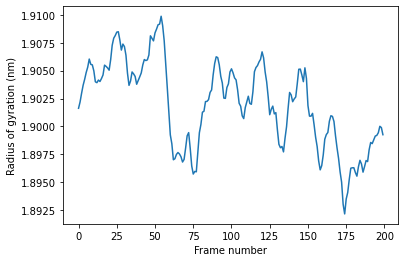

In [15]:
# Compute radius of gyration and plot it
rg_vals = md.compute_rg(traj)
plt.plot(rg_vals)
plt.ylabel("Radius of gyration (nm)")
plt.xlabel("Frame number")

Simultaneously, another feature we can plot is the Solvent Accessible Surface Area of a protein.

This is useful when understanding how a folded protein may be changing shapes along its surface, but is a lot tougher to make sense of by itself (you can read this in greater detail [here](https://mdtraj.org/1.9.4/examples/solvent-accessible-surface-area.html).)

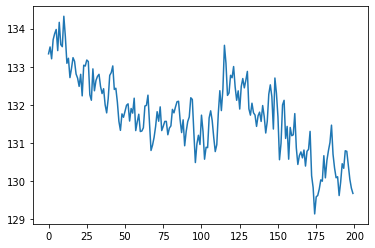

In [13]:
# compute solvent accessible surface area, sum it per frame, and then plot it
sasa = md.shrake_rupley(traj)
plt.plot(traj.time, sasa.sum(axis=1))

These plots are not very informative for a sample trajectory that only lasts 200 frames, but you may detect interesting behaviors as you collect larger and larger datasets!

One thing that is always useful to compute for any feature is the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation), which measures the correlation signal with a delayed copy of itself. This is a way to determine if the sampling from an MD Trajectory is truly a random process, indicating we have a degree of sufficient sampling. This is because many sophisticated analysis methods expect that your process being sampled is stochastic (i.e. random). 

This is done by defining an autocorrelation function, which broadly is:\
${R}_{XX}(t_1,t_2) = \operatorname{E} \left[ X_{t_1} \overline{X}_{t_2}\right]$

From a practical level, we can simply use a quick numpy function to define and plot the autocorrelation of our end-to-end distance.


In [16]:
def autocorr(x):
    "Compute an autocorrelation with numpy"
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    return result / result[0]


Text(0, 0.5, 'SASA autocorrelation')

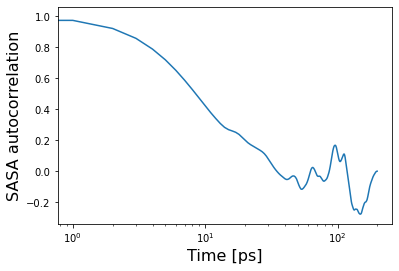

In [17]:
# plot the autocorrelation of the radius of gyration using a semi-log plot
plt.semilogx(traj.time, autocorr(rg_vals))
plt.xlabel('Time [ps]', size=16)
plt.ylabel('SASA autocorrelation', size=16)

Not bad! This tells us that that our end-to-end distance is not random, but does achieve stochasticity at about 10 picoseconds timescale! This is useful to know when we are modeling/subsampling our trajectories in the real world. We want to ensure that we are subsampling our frames to ensure our process is stochastic. Only then will our most powerful analytical tools be applicable.

There are _many_ other ways of thinking about analyzing simulations to study dynamics, allostery, and more from MD trajectories. The overview above only scratches the surface of what one can do. You'll need to check out the literature for more ideas!

One easy/predictable one to do is to compute the B-factors of the trajectory, and see if they correlate well with the crystal structure!

B-factors of a crystal structure (AKA temperature factors) are indicative of the mobility of a residue.\
It turns out there is a very easy conversion between the B-factor of a protein and the Root Mean Square Fluctuation:\
$B_i=\frac{8{\pi}^{2}}{3}(RMSF)^2$\, and likewise
${RMSF}_{i, exp} = (3B_i/8\pi^2)^{1/2}$

We can compute the RMSF of our trajectory using the `rmsf` function in MDTraj.\
This function computes the RMSF of each residue in the trajectory, and returns an array of RMSF values.\
We can then plot the RMSF of each residue using `matplotlib` to see how the RMSF changes over time.

RMSF is computed for any atomic position $i$:\
${RMSF}_{i,calc} = <(r_i(t) - <r_i(t)>)^2>^{1/2}$

In [31]:
# compute RMSF using MDTraj for each residue
rmsf = md.rmsf(traj, traj, atom_indices=traj.topology.select('backbone and name CA'))

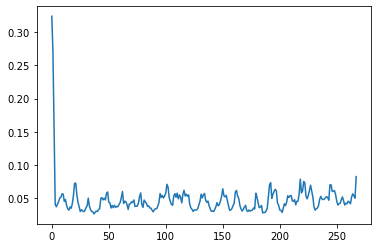

In [32]:
plt.plot(rmsf)